TASK 1 - 2

# Task 1

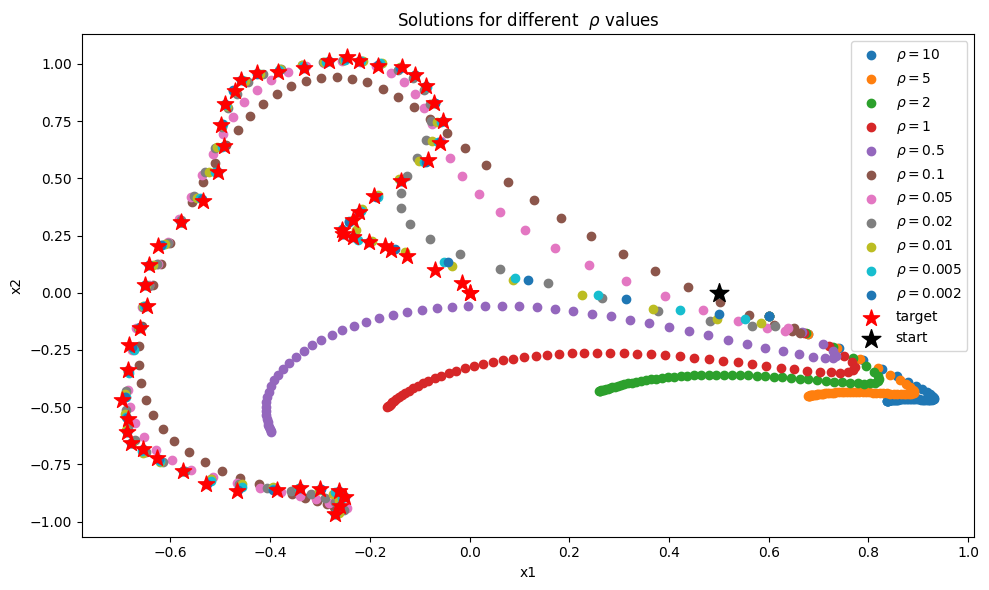

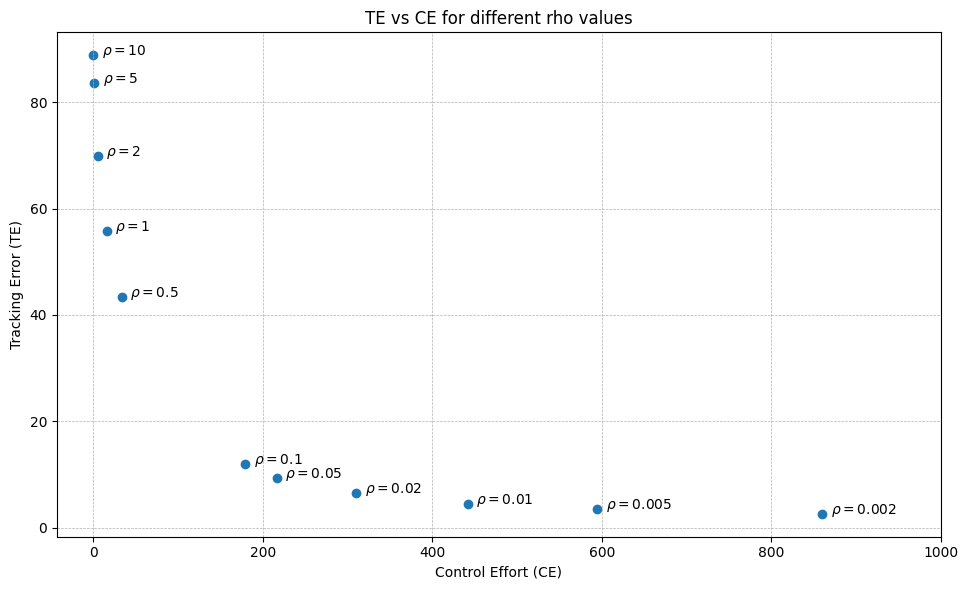

In [56]:
#imports
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
# load target
target = np.load("target_1.npy")


# define time horizon
T = len(target[0])
#define constants
A = np.array([[1, 0, 0.1, 0], [0, 1, 0, 0.1], [0, 0, 0.8, 0], [0, 0, 0, 0.8]])

B = np.array([[0, 0], [0, 0], [0.1, 0], [0, 0.1]])

E = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
# create cp variables
x = cp.Variable((4, T))
u = cp.Variable((2, T - 1))
# Tracking Error
TE = cp.sum([cp.norm(E @ x[:, t] - target[:, t], 2) for t in range(T)])

# Control Effort
CE = cp.sum_squares(u[:, : T - 1])
# define constraints
constraints = [x[:, 0] == np.array([0.5, 0, 1, -1])]

for t in range(T - 1):
    constraints += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t]]
# result storage
results = []

# define objective
rho = 10
TE_results = []
CE_results = []
rhos = [10, 5, 2, 1, 0.5, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002]
for rho in rhos:
    objective = cp.Minimize(TE + rho * CE)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    TE_results.append(TE.value)
    CE_results.append(CE.value)
    results.append((rho, x[0].value, x[1].value))
# plot tracking results
plt.figure(figsize=(10, 6))
for rho, x1, x2 in results:
    plt.scatter(x1, x2, label=fr"$\rho={rho}$")  # scatter is better for points

# plot target as a red star
plt.scatter(target[0], target[1], color="red", marker="*", s=150, label="target")
plt.scatter(0.5,0,marker="*",s=200, color="black", label="start")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title(r"Solutions for different  $\rho$ values")
plt.legend()
plt.tight_layout()
#plt.margins(x=0.15)
plt.savefig("solutions_plot.png", dpi=500) 
plt.show()
# plot TE vs CE for TASK 2
plt.figure(figsize=(10, 6))
plt.scatter(CE_results, TE_results)
#plt.scatter([0,1000],[0,100], linestyle="--", color="gray")
for i, rho in enumerate(rhos):
    plt.annotate(r"$\rho=$"+str(rho), xy=(CE_results[i]+10, TE_results[i]))
plt.xlabel("Control Effort (CE)")
plt.ylabel("Tracking Error (TE)")
plt.title("TE vs CE for different rho values")
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.margins(x=0.15)
plt.xlim(right=1000)
#plt.savefig("TE_vs_CE_plot.png", dpi=500)
plt.show()

The parameter $\rho$ determines how much weight the control effort is given in the optimization process. For a high $\rho$, for example $\rho=10$ the optimizer determines the control effect $CE$ to way more important than the tracking error $TE$, which means that the vehicle will not spend sufficient fuel to get on the track of the target.

As can be seen in the trajectory plot, instead of approaching the target trajectory the vehicle starts of going to the right. The initial velocity of the vehicle keeps it in that direction, as it cannot spend fuel to change direction, otherwise the control effort would be too great. In this case the optimizer reduces the control effort to zero while the tracking error remains high. As the weight of the control effort gets reduced ($\rho=10,5,\dots,0.5$) the vehicle starts to overcome the initial velocity and steers to the left, heading to the target trajectory to reduce the tracking error. However, as the control effort is still given alot of weight, the rapid changes in the target trajectory cannot be followed.

Only as the weight of $CE$ is reduced further ($\rho=0.1,0.05,\dots$) does the vehicle start to attach to the target. In this case the tracking error outweighs the fuel spent to counter the initial velocity in the wrong direction substantially. For the lowest values ($\rho=0.005,0.002$) the tracking error approaches zero while the control effort and therefore the fuel spent increases drastically (Figure 2). This leads the vehicle to quickly find the start of the target trajectory and follow it closely.
In summary, the relation between the different weights given to $CE$ and $TE$ and their reflection in the vehicle's behavior are intuitive and easily observable.

# Task 2

## Proof by Contradiction 

We want to solve the minimization problem with cost function  

$$f_{\rho} (x, u) = \sum_{t=1}^{T} \left \lVert Ex(t) - q(t) \right \rVert_2 + \sum_{t=1}^{T} \left \lVert u(t) \right \rVert_2 ^2$$

which gives the optimal pair $(x^*, u^*)$ that minimizes the cost.  

Let us denote by:  

- $TE_{\rho}^*$ the optimal tracking error at parameter $\rho$,  
- $CE_{\rho}^*$ the optimal control effort at parameter $\rho$.  

If $(x_a^*, u_a^*)$ is optimal for $\rho_a$:  

$TE_{\rho_a}^* + \rho_a \cdot CE_{\rho_a}^* <= TE_{\rho_b}^* + \rho_a \cdot CE_{\rho_b}^*$ (1)

Similarly, if $(x_b^*, u_b^*)$ is optimal for $\rho_b$, then 

$TE_{\rho_b}^* + \rho_b \cdot CE_{\rho_b}^* <= TE_{\rho_a}^* + \rho_b \cdot CE_{\rho_a}^*$ (2)

Define:
- $\Delta TE = TE_{\rho_b}^* - TE_{\rho_A}^*$
- $\Delta CE = CE_{\rho_b}^* - CE_{\rho_a}^*$

Premisses: 
- $TE_{\rho_a}^* \leq TE_{\rho_b}^* \rightarrow \Delta TE \geq 0$
- $\rho_a > 0$ 
- $\rho_b > 0$


Suppose $CE_{\rho_b} > CE_{\rho_a}$, which implies $\Delta CE > 0$. It holds true for the first equation, but equation (2) $\Delta CE = CE_{\rho_b}^* - CE_{\rho_a}^*$ would then require $\Delta CE <= 0$, which cannot be true because both terms are nonnegative and at least one is strictly positive.

This contradiction shows that the assumption $\Delta CE > 0$ is false. Therefore, $\Delta CE \leq 0$

$$CE_{\rho_a} \geq CE_{\rho_b}$$

# Task 3

We start with the system dynamics:
- for $t = 1 \Rightarrow x(1) = x_{initial}$ 
- for $t = 2 \Rightarrow x(2) = Ax_{initial} + Bu(1)$ 
- for $t = 3 \Rightarrow x(2) = A^2 x_{initial} + ABu(1) + Bu(2)$ 

So a general function for x(t) is 

$$x(t) = A^{t-1}x_{initial} + \sum_{k=1}^{t-1} A^{t-1-k}Bu(k)  $$

Hence the tracking error at time (t) is

$$\left \{ \begin{array}{l} Ex(t) + q(t) = c(t) + \sum_{k=1}^{t-1} g(k)u(k) \\ c(t) = EA^{t-1}x_{initial} - q(t) \\  g(k) = A^{t-1-k}B \end{array} \right .$$

Stacking over the horizon, let
- $z = \begin{pmatrix} Ex(1) - q(1) \\ Ex(2) - q(2) \\ \vdots \\ Ex(T) - q(T) \end{pmatrix} $
- $c = \begin{pmatrix} c(1) \\ c(2)) \\ \vdots \\ c(T) \end{pmatrix} $
- $u = \begin{pmatrix} u(1) \\ u(2)) \\ \vdots \\ u(T) \end{pmatrix} $

then, $z = c + Gu$, where G is a lower triangle matrix: $G = \begin{bmatrix}
0 & 0 & 0 & \cdots & 0 \\
g(2,1) & 0 & 0 & \cdots & 0 \\
g(3,1) & g(3,2) & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \ddots & \vdots \\
g(T,1) & g(T,2) & \cdots & g(T,T-1) & 0
\end{bmatrix}.$

The tracking error term is
$
TE = \sum_{t=1}^T |Ex(t) - q(t)|_2^2 = |z|_2^2 = |c + Gu|_2^2,
$
which is a convex quadratic function of (u).

The control effort term is
$
CE = \sum_{t=1}^T |u(t)|_2^2 = |u|_2^2,
$
which is strongly convex in (u).

Therefore, the full cost is $ f_\rho(u) = |c + Gu|_2^2 + \rho |u|_2^2, \rho > 0.$ which is a strong convex function. Therefore the minimization problem has a unique solution.

# Task 4

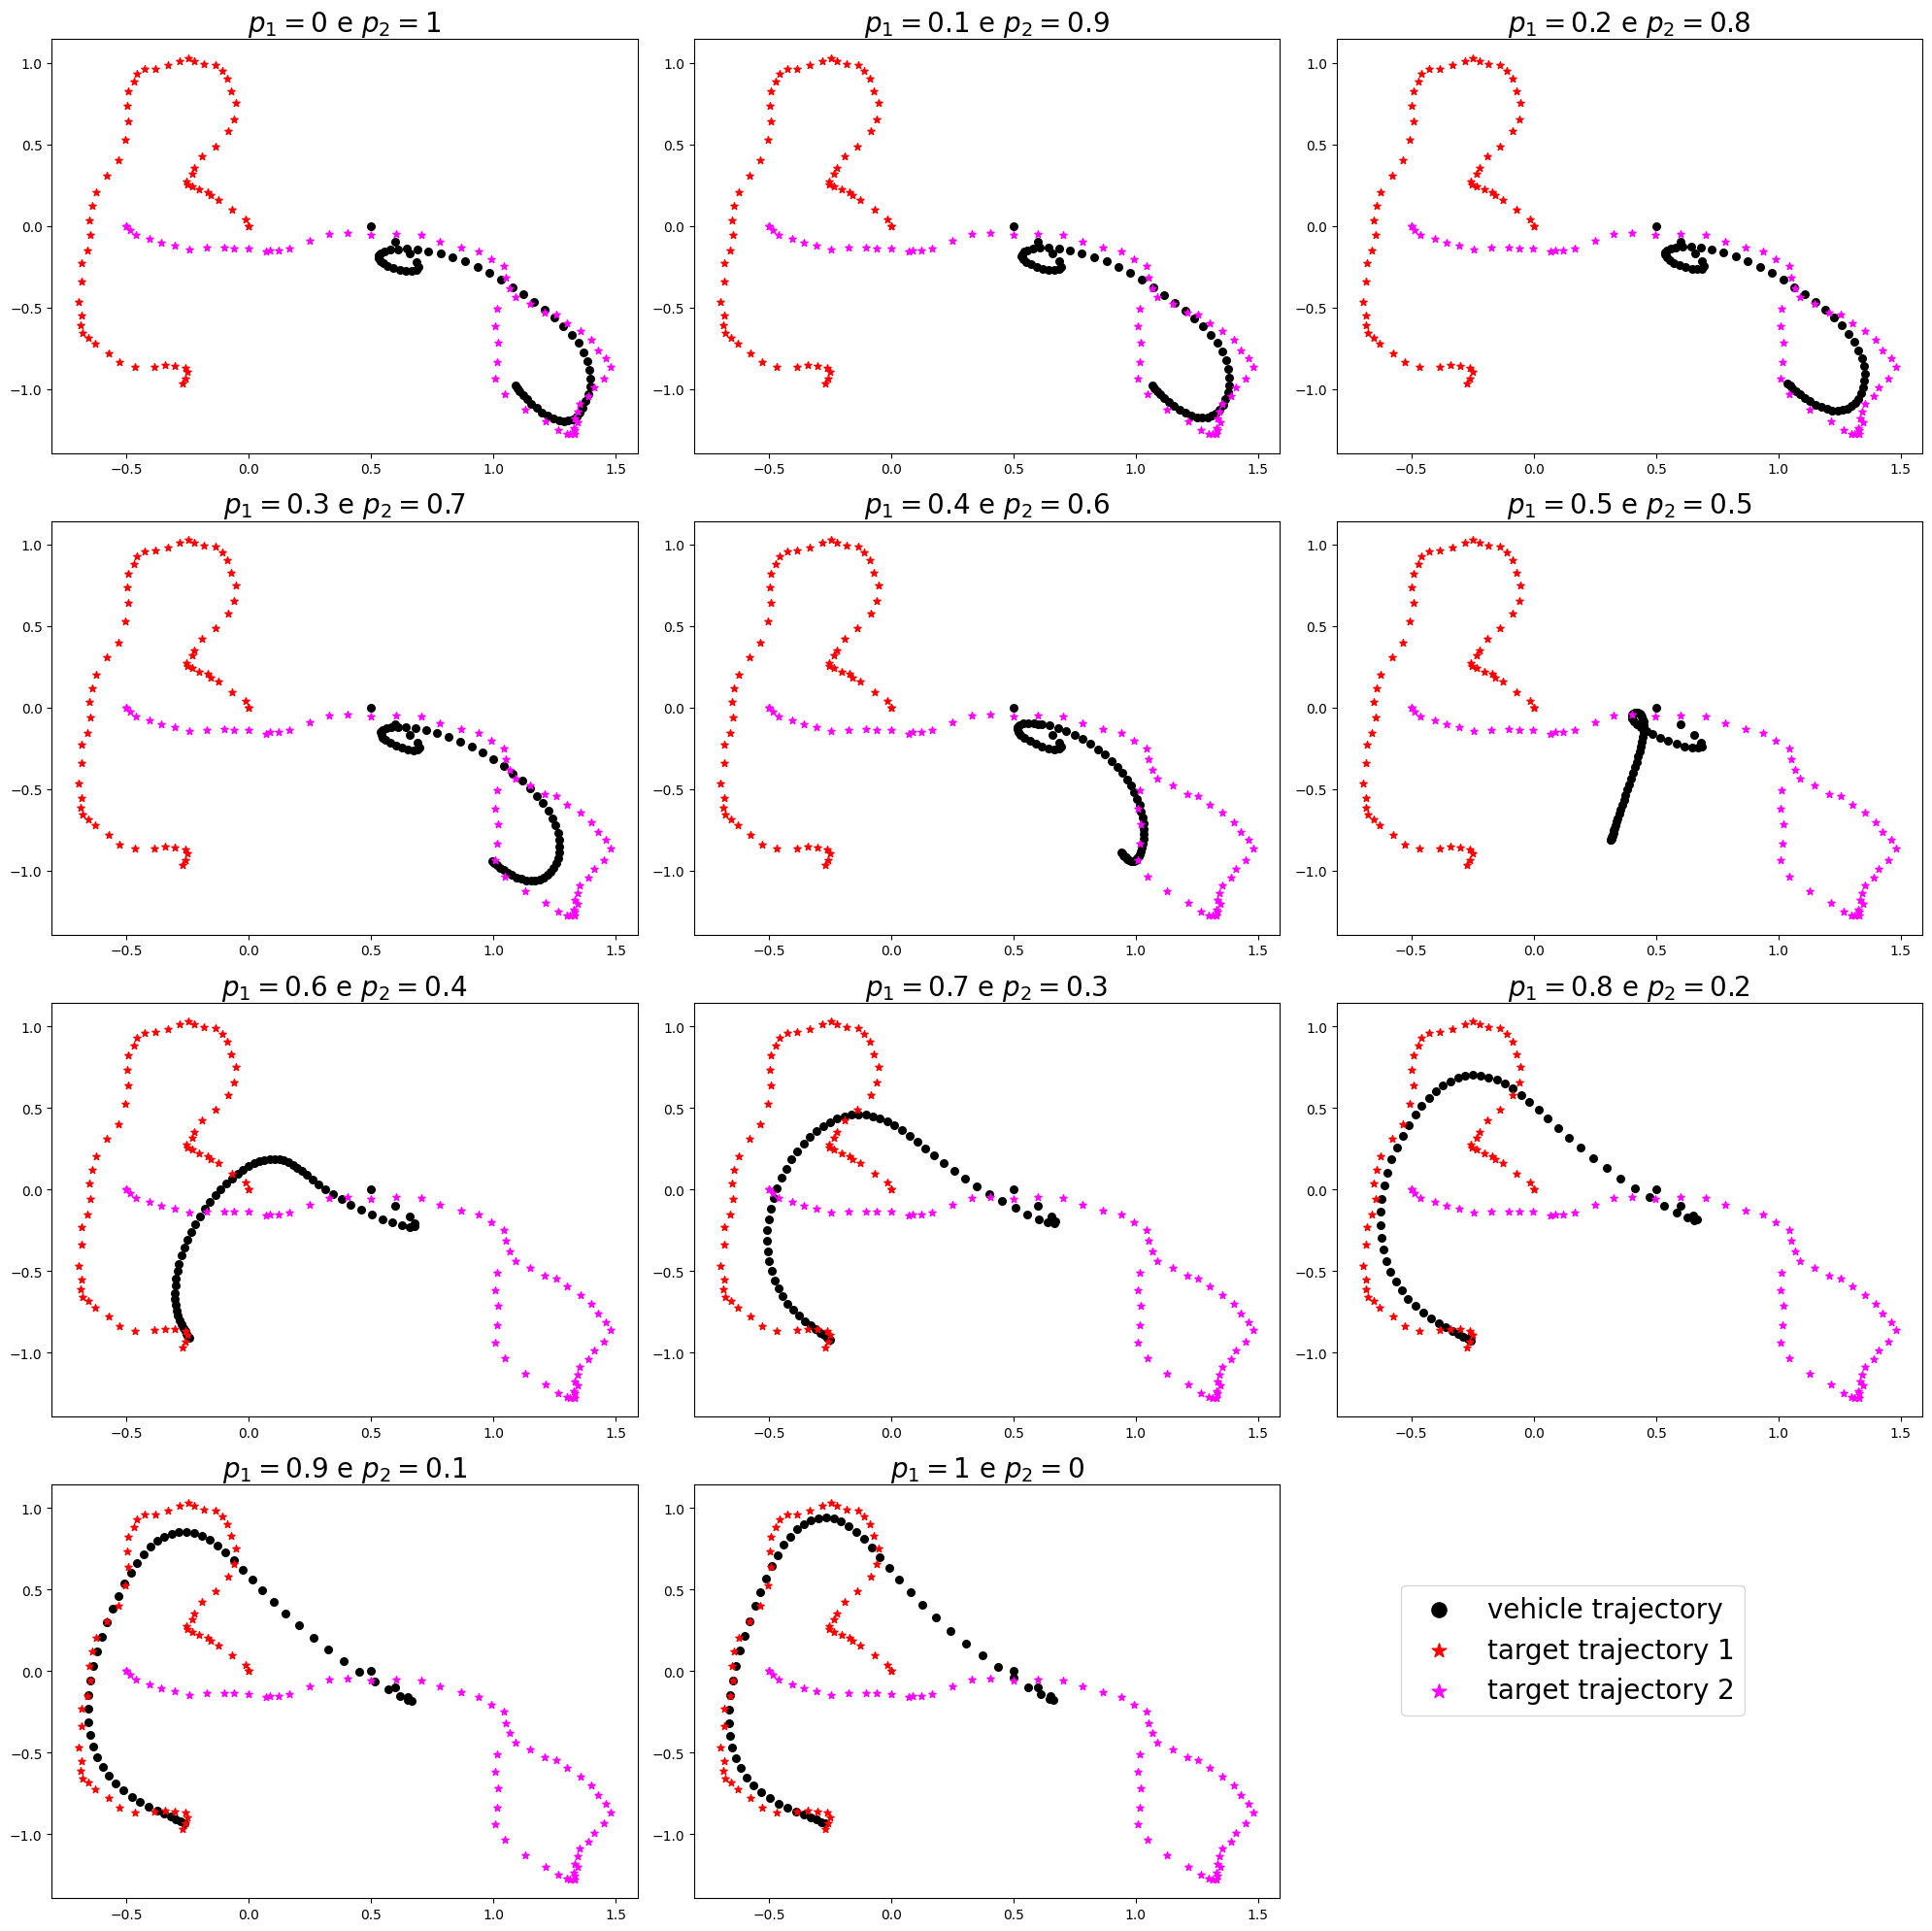

In [57]:
# load target
target_1 = np.load("target_1.npy")
target_2 = np.load("target_2.npy")


# define time horizon
T = len(target_1[0])
# Tracking Error
TE_1 = cp.sum([cp.norm(E @ x[:, t] - target_1[:, t], 2) for t in range(T)])
TE_2 = cp.sum([cp.norm(E @ x[:, t] - target_2[:, t], 2) for t in range(T)])

# Control Effort
CE = cp.sum_squares(u[:, : T - 1])
# result storage
results = []

# define objective
rho = 10
TE_1_results = []
TE_2_results = []
CE_results = []
rho = 0.1

for p1, p2 in [(0,1) ,(0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1), (1,0)]:
    objective = cp.Minimize(p1*TE_1 + p2*TE_2 + rho * CE)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    TE_1_results.append(TE_1.value)
    TE_2_results.append(TE_2.value)
    CE_results.append(CE.value)
    results.append((p1, x[0].value, x[1].value))
# plot tracking results
plt.figure(figsize=(20,20))
for i, (p1, x1, x2) in enumerate(results):
    plt.subplot(4,3,i+1)
    plt.title(fr"$p_1 = {p1}$ e $p_2 = {round(1-p1,1)}$", fontsize=20)
    plt.scatter(x1, x2, color="black", s=30, label="vehicle trajectory")
    plt.scatter(target_1[0], target_1[1], color="red", marker="*", s=30, label="target trajectory 1")
    plt.scatter(target_2[0], target_2[1], color="magenta", marker="*", s=30, label="target trajectory 2")
    plt.tight_layout()

# Add a global legend in the bottom-right
plt.legend(
    loc='center',
    bbox_to_anchor=(1.5, 0.6),
    fontsize=20,
    markerscale=2,
    frameon=True,
)

plt.show()

In the two cases where $(p_1,p_2)=(0,1)$ and $(p_1,p_2)=(1,0)$ the target trajectory is deterministic, therefore the vehicle follows only one target in a similar fashion of Task 1. The set weight of $\rho=0.1$ gives the optimizer a good compromise between the control effort and the tracking error, as can be seen in the second plot of Task 1. In the first plot for $p_1=0$ and $p_2=1$ the vehicle clearly tracks trajectory 2 on the right after some time has passed, as the initial velocity has to be accounted for.

Now, as the probability $p_1$ for trajectory 1 increases while the probability for trajectory 2 decreases, it can be observed that the optimized vehicle trajectory slowly begins to deviate form trajectory 1 and is seemingly pulled to the left where the second trajectory lies. This makes sense, because when $p_2$ increases the weight of trajectory 2 increases in the average tracking error. Consequently, for the case where both trajectory probabilities are equal the vehicle follows a line which seems to be of equal distance to both trajectories. Again, this happens after the initial velocity of the vehicle is compensated after which the vehicle is pulled to the center of both trajectories.

For the reverse case where $p_1>p_2$ it can be observed that the vehicle approaches the first target trajectory with every increase in $p_1$. Of course the smaller probability $p_2$ for the second target trajectory leads to a smaller fraction in the average tracking error and therefore effect in the optimization process.

# Task 5

Currently, the optimization formulation (5) models two **independent** vehicles, as the values $(x_1,u_1)$ and $(x_2,u_2)$ are not coupled. The problem is seperated over $k\in\{1,2\}$:
$$\min_{x_1,u_1}p_1\left(\sum_{t=1}^T\|Ex_1(t)-q_1(t)\|_2 + \rho\sum_{t=1}^T\|u_1(t)\|_2^2\right) +\min_{x_2,u_2}p_2\left(\sum_{t=1}^T\|Ex_2(t)-q_2(t)\|_2 + \rho\sum_{t=1}^T\|u_2(t)\|_2^2\right)$$
Each trajectory is optimized as if we knew from the start which target path will occur. In this state the optimization problem is overly optimistic in regard to the achievable minimum. For example, if the trajectory of target 1 goes strictly to the left and the trajectory of target 2 strictly to the right, the vehicle in the realizable problem must pick one before reveal. Therefore, the expected tracking error is strictly larger in comparison to the uncoupled formulation.

# Task 6

Before $t=25$ we don't know which trajectory the vehicle should follow. The vehicle therefore has a single state $x(t)$ up to that time. To model this coupling we can constrain the control inputs $u_1(t)$ and $u_2(t)$ to be equal. Consequently, the vehicle follows the same path until the true target trajectory is revealed at $t=25$. After this point the trajectories are decoupled and the trajectories get optimized for the separate control inputs. This leads to the following complete optimization formulation:
$$
\begin{array}{ll}
\displaystyle \min_{x_1,u_1,x_2,u_2} &
\displaystyle \sum_{k=1}^{K} p_k \left(
  \sum_{t=1}^{T} \left\| E\,x_k(t) - q_k(t) \right\|_2
  + \rho \sum_{t=1}^{T-1} \left\| u_k(t) \right\|_2^2
\right)
\\[1ex]
\mbox{subject to} &
x_1(1) = x_2(1) = x_{\mathrm{initial}}, \\[0.3ex]
&
x_1(t+1) = A\,x_1(t) + B\,u_1(t), \;\; 1 \le t \le T-1, \\[0.3ex]
&
x_2(1) = x_{\mathrm{initial}}, \\[0.3ex]
&
x_2(t+1) = A\,x_2(t) + B\,u_2(t), \;\; 1 \le t \le T-1, \\[0.8ex]
&
u_1(t) = u_2(t), \;\; 1 \le t \le 24,
\end{array}
$$


# Task 7

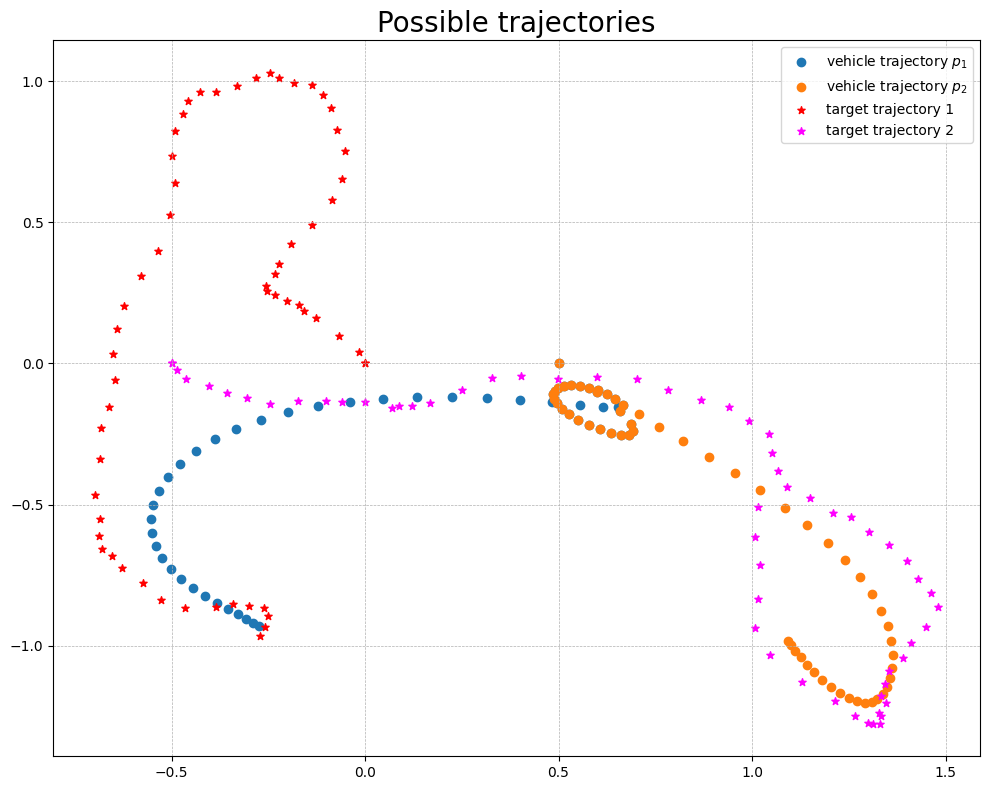

In [58]:
#load target
target_1 = np.load("target_1.npy")
target_2 = np.load("target_2.npy")


# define time horizon
T = len(target_1[0])

x1 = cp.Variable((4, T))
u1= cp.Variable((2, T - 1))
x2 = cp.Variable((4, T))
u2= cp.Variable((2, T - 1))
# Tracking Error
TE1 = cp.sum([cp.norm(E @ x1[:, t] - target_1[:, t], 2) for t in range(T)])
TE2 = cp.sum([cp.norm(E @ x2[:, t] - target_2[:, t], 2) for t in range(T)])

x_init = np.array([0.5, 0, 1, -1])
constraints = [x1[:, 0] == x_init, x2[:, 0] == x_init]
for t in range(T - 1):
    constraints.append(x1[:, t + 1] == A @ x1[:, t] + B @ u1[:, t])
    constraints.append(x2[:, t + 1] == A @ x2[:, t] + B @ u2[:, t])
    if t < 24:
        constraints.append(u1[:,t] == u2[:,t])
        constraints.append(x1[:,t] == x2[:,t])
# Control Effort
CE1 = cp.sum_squares(u1[:, : T - 1])
CE2 = cp.sum_squares(u2[:, : T - 1])

# define objective
rho = 0.1
p1 = 0.4
p2 = 0.6

objective = cp.Minimize(p1*(TE1 + rho * CE1) + p2*(TE2 + rho * CE2))
prob = cp.Problem(objective, constraints)
prob.solve()

# plot tracking results
plt.figure(figsize=(10, 8))
plt.scatter(x1[0].value, x1[1].value, label=r"vehicle trajectory $p_1$")
plt.scatter(x2[0].value, x2[1].value, label=r"vehicle trajectory $p_2$")
# plot target as a red star
plt.scatter(target_1[0], target_1[1], color="red", marker="*", s=30, label="target trajectory 1")
plt.scatter(target_2[0], target_2[1], color="magenta", marker="*", s=30, label="target trajectory 2")
plt.title(r"Possible trajectories",fontsize=20)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Task 8

The cost function f:
$$ f(c,R) = \sum_{{n=1}}^{N}(\lVert c - x_{n} \rVert_{2} - R)²
$$
The proof that f is not convex is done by finding a counterexample that violates the definition of convexity:$$ f(\alpha z_{1} + (1-\alpha)z_{2}) \le \alpha f(z_{1}) + (1-\alpha)f(z_{2}) $$
 Therefore in the simple case of testing only the midpoint of the chord ($\alpha=0.5$) the condition becomes:
$$ f\left( \frac{z_{1}+z_{2}}{2} \right)> \frac{1}{2}f(z_{1})+\frac{1}{2}f(z_{2})$$
to show non-convexity.
Considering the simple test data of $N$= 1, $x_1$ = (0,0):
$$ f(c,R) = (\lVert c-x_{1} \rVert _{2} -R)² = (\lVert c \rVert _{2}-R)²$$
Choosing two points:
- $z_{1} = (c_{1},R_{1})$ where $c_{1} = (1,0)$ and $R_{1} = 1$
- $z_{2} = (c_{2},R_{2})$ where $c_{2} = (-1,0)$ and $R_{2} = 1$

Computing function values:
- $f(z_{1})=f((1,0),1) =(\sqrt{1²+0²}-1)² =0$
- $f(z_{2})= f((-1,0),1) =(\sqrt{ (-1)²+0 }-1)²=0$

Computing the midpoint:
$$ z_{mid} =\frac{z_{1}+z_{2}}{2}=\frac{1}{2}[(1,0),1] + \frac{1}{2}[(-1,0),1]= \left(\frac{(1,0)+(-1,0)}{2},\frac{(1+1)}{2} \right)=((0,0),1)$$
$c_{\text{mid}}=(0,0)$ and $R_{\text{mid}}=1$

Evaluating the midpoint:
$$f(z_{\text{mid}})=f((0,0),1)=(\lVert (0,0) \rVert -1)²=(0-1)² = 1$$

Comparing to right side:
$$ f(z_{\text{mid}})=1 > 0 = \frac{f(z_{1})+f(z_{2})}{2}$$
A counterexample has been found, therefore $f(c,R)$ **is non-convex**

# Task 9

comment: the description of the task does not coincide with the graphs provided. In fact the data points that has to be used for the real LSE problem are circle_data_1, not circle_data_2, and to get the correct solution the data from the two file needs to be stacked together.

Solution (y_star, c_star):  [ 1.15943005 -1.06211003  0.99475605]
R_star:  [0.97887041]
Solution (y_star, c_star):  [ 1.04797694 -0.98365101  1.04351846]
R_star:  [1.00425253]


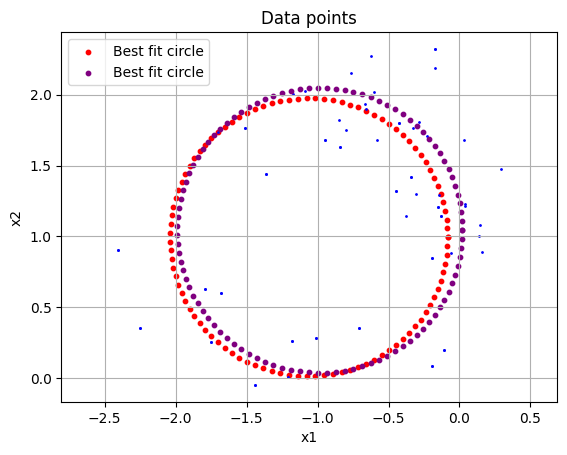

In [59]:
def circle(data_points):
  
    A = np.empty((len(data_points[0]), 3))
    A[:,0] = np.ones((len(data_points[0]), 1), dtype=int).flatten()
    A[:,1] = -2*data_points[0]
    A[:,2] = -2*data_points[1]

    b = np.array(np.linalg.norm(data_points, axis = 0)**2).reshape(len(data_points[0]),1)

    sol = np.linalg.lstsq(A, -b, rcond=None)[0]     #[0] to get only the first element of the tuple
    print("Solution (y_star, c_star): ", sol.flatten())

    R_star = np.sqrt(np.linalg.norm(sol[1:])**2-sol[0])
    print("R_star: ", R_star)

    # plot the circle
    theta = np.linspace(0, 2 * np.pi, 100)
    y_star = sol[0]
    c_star = sol[1:]
    x_circle = c_star[0] + R_star * np.cos(theta)
    y_circle = c_star[1] + R_star * np.sin(theta)

    return x_circle, y_circle

#---------------------------------#-----------------#
# Experimental Circle Fitting
data_points = np.load("circle_data_1.npy")

plot = plt.figure()
plt.scatter(data_points[0], data_points[1], color="blue", s=1)
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid()
plt.title("Data points")

x_circle, y_circle = circle(data_points)

plt.scatter(x_circle, y_circle, color="red", label="Best fit circle", s=10)

#---------------------------------#---------------------------------#---------------------------------#

# Ground Truth Circle Fitting
data_points = np.load("circle_data_1.npy")
x_points = data_points[0]
y_points = data_points[1]
add_points = np.load("circle_data_2.npy")
x_points_add = add_points[0]
y_points_add = add_points[1]
x_points = np.hstack((x_points, x_points_add))
y_points = np.hstack((y_points, y_points_add))
data_points = np.vstack((x_points, y_points))

plt.scatter(data_points[0], data_points[1], color="blue", s=1)

x_circle, y_circle = circle(data_points)

plt.scatter(x_circle, y_circle, color="purple", label="Best fit circle", s=10)
plt.legend()

# Task 10

 Derivation of analitic formula for Levenberg–Marquardt

Let $ s(x) \in \mathbb{R}^m $ be the vector defined as ( $ s_i(x) = f_i(x) $)  
and $ J(x) \in \mathbb{R}^{m \times n} $ the Jacobian evaluated in $ x $.

At the step $ k $,  $ x_k $ is fixed and we look for the increment $ \Delta x $ that minimizes  
the Levenberg–Marquardt function, with a scalar damping parameter $ \lambda $:

$$
\min_{\Delta x \in \mathbb{R}^n} \; \Phi(\Delta x)
= \min_{\Delta x} \; \| s(x_k) + J(x_k)\,\Delta x \|^2 + \lambda\,\|\Delta x\|^2
$$

The notation is simplified taking $s_k = s(x_k)$ e $J_k = J(x_k)$. Then:

$$
\Phi(\Delta x) = (s_k + J_k \Delta x)^\top (s_k + J_k \Delta x) + \lambda \, \Delta x^\top \Delta x
$$

Developing the square:

$$
\Phi(\Delta x) = s_k^\top s_k + 2 \, s_k^\top J_k \Delta x + \Delta x^\top J_k^\top J_k \Delta x + \lambda \, \Delta x^\top \Delta x
$$

To find the minima, the gradient with respect to $ \Delta x $ is calculated and equalled to zero:

$$
\nabla_{\Delta x} \Phi(\Delta x) = 2 \, J_k^\top s_k + 2 \, (J_k^\top J_k) \Delta x + 2 \lambda \, \Delta x = 0
$$

Dividing by two and grouping $ \Delta x $:

$$
(J_k^\top J_k + \lambda I) \, \Delta x = - J_k^\top s_k
$$

Assuming  $ J_k^\top J_k + \lambda I $ invertible, the solution for the increment is found:

$$
\boxed{ \Delta x = - (J_k^\top J_k + \lambda I)^{-1} J_k^\top s_k }
$$

Finally, the parameter is updated:

$$
x_{k+1} = x_k + \Delta x
$$



Convergence reached at iteration 6
Final_values:
Center = (-1.0600, 0.9523)
Radius = 0.9443

Center LM: (-1.05997, 0.95235)
Radius LM: 0.94427


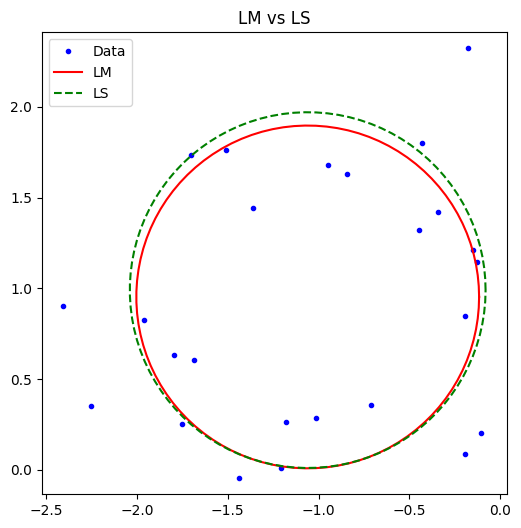

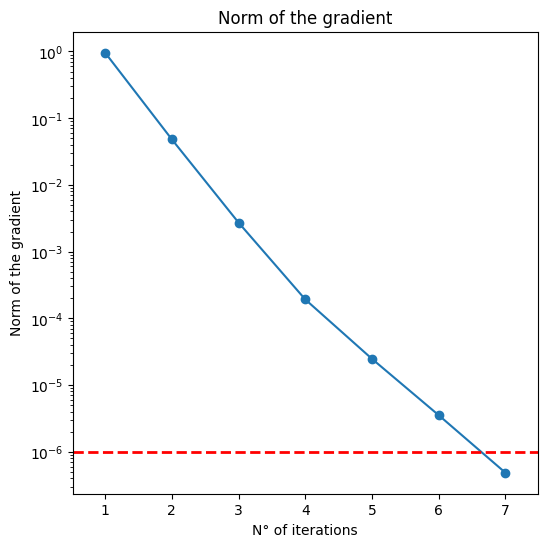

In [60]:
# Loading data
data = np.load('circle_data_1.npy')
if data.shape[0] == 2:
    data = data.T
x = data[:, 0]
y = data[:, 1]

# Parameters
lam = 1.0
tolerance = 1e-6
gradient_norms = []
cls = (-1.06, 0.99)
Rls = 0.98
xk = np.array([cls[0], cls[1], Rls])

# Functions
def r(p):
    a, b, R = p
    return np.sqrt((x - a)**2 + (y - b)**2) - R

def J(p):
    a, b, R = p
    d = np.sqrt((x - a)**2 + (y - b)**2)
    J = np.zeros((len(x), 3))
    J[:, 0] = (a - x) / d
    J[:, 1] = (b - y) / d
    J[:, 2] = -1
    return J

k = 0
k_list = []
gk_norm_list = []

# Iterative process
while True:
    rk = r(xk)
    Jk = J(xk)
    gk = Jk.T @ rk
    gk_norm = np.linalg.norm(gk)

    # Store for visualization
    k_list.append(k + 1)
    gk_norm_list.append(gk_norm)

    # Stop criteria
    if gk_norm < tolerance:
        print(f"Convergence reached at iteration {k}")
        break

    #formula for x
    # Δx* = - (JᵀJ + λI)⁻¹ Jᵀ r
    A = Jk.T @ Jk + lam * np.eye(3)
    delta = -np.linalg.inv(A) @ (Jk.T @ rk)

    # new x
    x_candidate = xk + delta

    
    cost_current = np.sum(rk**2)
    cost_candidate = np.sum(r(x_candidate)**2)

    if cost_candidate < cost_current:
        xk = x_candidate
        lam *= 0.7  
    else:
        lam *= 2.0  

    k += 1

# final result
print("Final_values:")
print(f"Center = ({xk[0]:.4f}, {xk[1]:.4f})")
print(f"Radius = {xk[2]:.4f}")

#final result
clm = xk[:2]
Rlm = xk[2]
print(f"\nCenter LM: ({clm[0]:.5f}, {clm[1]:.5f})")
print(f"Radius LM: {Rlm:.5f}")

#plot
theta = np.linspace(0, 2*np.pi, 100)
circle_lm_x = clm[0] + Rlm * np.cos(theta)
circle_lm_y = clm[1] + Rlm * np.sin(theta)
circle_ls_x = cls[0] + Rls * np.cos(theta)
circle_ls_y = cls[1] + Rls * np.sin(theta)

plt.figure(figsize=(6,6))
plt.plot(x, y, 'b.', label='Data')
plt.plot(circle_lm_x, circle_lm_y, 'r-', label='LM')
plt.plot(circle_ls_x, circle_ls_y, 'g--', label='LS')
plt.axis('equal')
plt.legend()
plt.title('LM vs LS')
plt.show()

plt.figure(figsize=(6,6))
plt.semilogy(k_list, gk_norm_list, '-o')
plt.axis('equal')
plt.axhline(y=tolerance, color='red', linestyle='--', linewidth=2, label=f'Tolerance = {tolerance}')
plt.title('Norm of the gradient')
plt.xlabel('N° of iterations')
plt.ylabel('Norm of the gradient')
plt.show()

Although not required, it is interesting to explore how the implemented Levenberg-Marquardt (LM) method performs when no initial guesses for the center and radius are provided. Assuming the linear problem has not been solved, heuristic assumptions can still be made to estimate a reasonable starting point without relying on a separate optimization procedure. One of most straightforward one could be taking the mean point of the dataset provided as the center, and the mean between the furthest distance and the smallest distance between two points as radius.\
To check robustness however, here worse initial values are considered:

Center: the minimum and maximum of x and y coordinates are taken, and the 4 'worst-case centers' are considered as the combination between them\
Radius: as a starting radius, is taken the minimum and the maximum distance between two points
 
This choices are made not to consider a real 'worst case approach' (initial center and radius could go to infinite), but more like as a 'worst case approach with reasonable values'.\
Checking all the eight combinations, the LM method converged always, at most in 12 iterations; however, in some cases the 2nd, 3rd and 4th iterations were worse than the 1st, considering 0 the starting point, but never worse than it, hinting that non-convergence could be not far from the starting points considered. This does not prove that there isn't any combinations between the values used that makes the problem diverge (or maybe it does, but the writer doesn't know if such a proof exists); however, it hints that it is not necessary to have a precise starting point in order to reach convergence. Still, this is true for this dataset, but could be wrong for another one. 

# Task 11

Solution (y_star, c_star):  [61.24964782  2.97016417  7.48830003]
R_star:  [1.9096766]
Solution (y_star, c_star):  [51.07035223 -1.76271617  7.09397824]
R_star:  [1.53666631]
Solution (y_star, c_star):  [12.97847125 -1.93484879  3.33716264]
R_star:  [1.37906602]
Solution (y_star, c_star):  [10.51591717  2.67170265  2.69527835]
R_star:  [1.971447]
Algorithm converged in 4 ALM iterations.
Final circle parameters (u_0, u_1, u_2):
[-10.31266624  -1.22140775  -5.04943058]


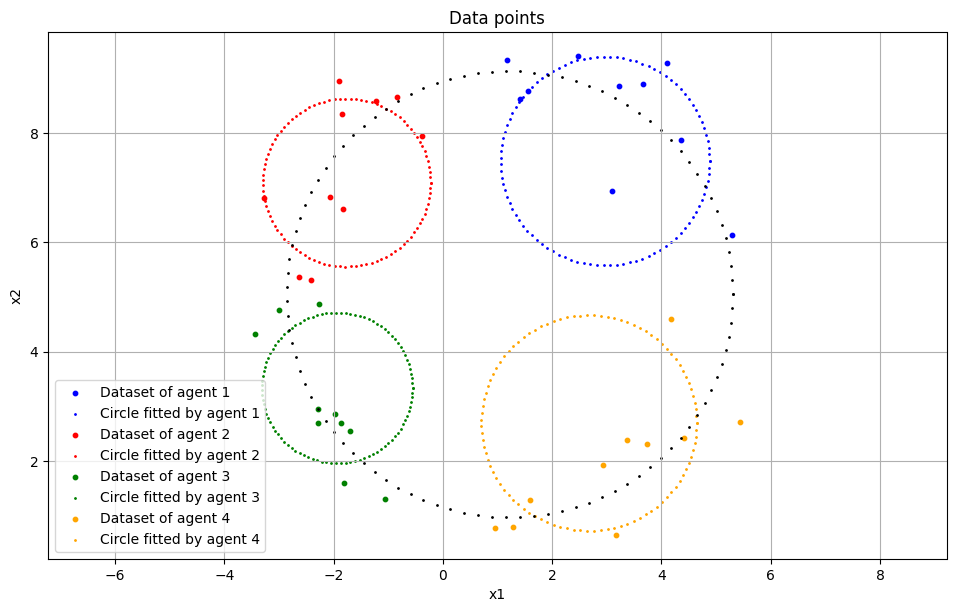

In [68]:
plot = plt.figure(figsize=(10,6))
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.grid()
plt.tight_layout()
plt.title("Data points")

class agent:
    def __init__(self, id, data_points,color):
        self.id = id
        self.data_points = data_points
        self.x_circle, self.y_circle = circle(data_points)
        self.color = color
        self.x_p = np.zeros((3, 1))
        self.lamb = np.zeros((3, 1))
    def update(self, x_p):
        self.x_p = x_p
        
class server:
    def __init__(self):
        self.x_0 = np.zeros((3, 1))
        self.x_center, self.y_center = self.x_0[1], self.x_0[2]
        self.color = "black"

    def plot(self, plt):
        u_0, u_1, u_2 = self.x_0.flatten() # Flatten for easy access
        x_center = -u_1
        y_center = -u_2
        R = np.sqrt(x_center**2 + y_center**2 + u_0)  
        theta = np.linspace(0, 2 * np.pi, 100)
        x_circle = x_center + R * np.cos(theta)
        y_circle = y_center + R * np.sin(theta)
        plt.scatter(x_circle, y_circle, color=self.color, label=f"Circle fitted by FL", s=1)


   
agents = []
agents.append(agent(1, np.load("dataset1.npy"), "blue"))
agents.append(agent(2, np.load("dataset2.npy"), "red"))
agents.append(agent(3, np.load("dataset3.npy"), "green"))
agents.append(agent(4, np.load("dataset4.npy"), "orange"))

for agent in agents:
    plt.scatter(agent.data_points[0], agent.data_points[1], color=agent.color, label=f"Dataset of agent {agent.id}", s=10)
    plt.scatter(agent.x_circle, agent.y_circle, color=agent.color, label=f"Circle fitted by agent {agent.id}", s=1)

plt.legend(loc='lower left')

server = server()

# initialize ALM 
k = 1
c = 100
eps_ALM = 0.01
eps_BCD = 0.01
diff_ALM = [np.inf for _ in agents]
u_0_m = server.x_0

# STEP 1: while cycle until the norm of the difference between x_0 and every x_p is less than eps_ALM
while any(diff > eps_ALM for diff in diff_ALM):
# STEP 2: initialize the variable of BCD -> m, u_0k
    diff_BCD = np.inf
    m = 1
    u_p = np.zeros((len(agents), 3, 1))

    # STEP 3: while cycle until the norm of the difference between u_0_m and u_0_m-1 is less than eps_BCD
    while(diff_BCD > eps_BCD):
        u_0_m_1 = u_0_m.copy()

        for i, agent in enumerate(agents):
            # STEP 4: optimization for u_p 
            A_p = np.empty((len(agent.data_points[0]), 3))
            A_p[:,0] = np.ones((len(agent.data_points[0]), 1), dtype=int).flatten()
            A_p[:,1] = -2*agent.data_points[0]
            A_p[:,2] = -2*agent.data_points[1]

            b_p = np.array(np.linalg.norm(agent.data_points, axis = 0)**2).reshape(len(agent.data_points[0]),1)

            A = 2*A_p.T @ A_p + c*np.eye(3)
            b = 2*A_p.T @ b_p + agent.lamb + c*u_0_m
            solution = np.linalg.lstsq(A, b, rcond=None)[0]    # Note: not sure that A is invertible -> use lstsq
            u_p[i,] = solution

        # STEP 5: optimization for u_0
        # Note: derivative of Lagrangian set to 0 and solved for u_0
        u_0_m = np.zeros((3, 1)) # Start from zero

        for i, agent in enumerate(agents):
            u_0_m += (c*u_p[i,] - agent.lamb)/(len(agents)*c)

        diff_BCD = np.linalg.norm(u_0_m - u_0_m_1)
        m += 1

    # STEP 6: update x_0
    server.x_0 = u_0_m
    for i, agent in enumerate(agents):
        agent.update(u_p[i,])
        # STEP 7: update lambda
        agent.lamb = agent.lamb +  c * (server.x_0 - agent.x_p)
        # STEP 8: update diff_ALM
        diff_ALM[i] = (np.linalg.norm(server.x_0 - agent.x_p)) / np.linalg.norm(server.x_0)
    k += 1  

# At this point we have the solution stre in server.x_0 and it corresponds to y and the coordinates of the center of the circle
server.plot(plt)

print(f"Algorithm converged in {k-1} ALM iterations.")
print(f"Final circle parameters (u_0, u_1, u_2):\n{server.x_0.flatten()}")